In [1]:
from pycigar.envs import Env
import yaml

import numpy as np
from scipy import signal
import math
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]

class FooEnv(Env):
    @property
    def observation_space(self):
        return Box(low=-float('inf'), high=float('inf'),
                   shape=(5,), dtype=np.float64)

    @property
    def action_space(self):
        return Box(low=0.5, high=1.5, shape=(5,), dtype=np.float64)

    def step(self, rl_actions=None, randomize_rl_update=None):
        """See parent class.
        """

        for _ in range(self.sim_params['env_config']["sims_per_step"]):
            self.env_time += 1
            
            # perform action update for PV inverter device
            if len(self.k.device.get_adaptive_device_ids()) > 0:
                control_setting = []
                for device_id in self.k.device.get_adaptive_device_ids():
                    action = self.k.device.get_controller(device_id).get_action(self)
                    control_setting.append(action)
                self.k.device.apply_control(self.k.device.get_adaptive_device_ids(), control_setting)
                
            # perform action update for PV inverter device
            if len(self.k.device.get_battery_storage_device_ids()) > 0:
                control_setting = []
                for device_id in self.k.device.get_battery_storage_device_ids():
                    action = self.k.device.get_controller(device_id).get_action(self)
                    control_setting.append(action)
                self.k.device.apply_control(self.k.device.get_battery_storage_device_ids(), control_setting)

            # perform action update for PV inverter device
            if len(self.k.device.get_fixed_device_ids()) > 0:
                control_setting = []
                for device_id in self.k.device.get_fixed_device_ids():
                    action = self.k.device.get_controller(device_id).get_action(self)
                    control_setting.append(action)
                self.k.device.apply_control(self.k.device.get_fixed_device_ids(), control_setting)

            self.additional_command()

            if self.k.time <= self.k.t:
                self.k.update(reset=False)

                # check whether the simulator sucessfully solved the powerflow
                converged = self.k.simulation.check_converged()
                if not converged:
                    break

            if self.k.time >= self.k.t:
                break

        # the episode will be finished if it is not converged.
        done = not converged or (self.k.time == self.k.t)
        obs = self.get_state()
        infos = {}
        reward = self.compute_reward(rl_actions)

        return obs, reward, done, infos

    def get_state(self):
        return [0, 0, 0, 0, 0]

    def compute_reward(self, rl_actions, **kwargs):
        return 0

stream = open("./data/pycigar_config.yaml", "r")
sim_params = yaml.safe_load(stream)

print('Simulation Complete')

Simulation Complete


In [2]:
env = FooEnv(sim_params)
env.reset()
done = False
while not done:
    _, _, done, _ = env.step()
    
print('Simulation Complete')

<class 'pycigar.controllers.fixed_controller.FixedController'>
<class 'pycigar.controllers.battery_storage_controller_01.BatteryStorageController01'>
Simulation Complete


In [3]:
from pycigar.utils.logging import logger

Logger = logger()

Logger.log_dict.keys()

dict_keys(['pv_1', 'adversary_pv_1', 'bsd_1', 's701a', 's702a', 's703a', 'network'])

In [4]:
env.k.device.devices

{'pv_1': {'device': <pycigar.devices.pv_inverter_device.PVDevice at 0x7fbe546ac0d0>,
  'controller': <pycigar.controllers.fixed_controller.FixedController at 0x7fbe54701690>,
  'node_id': 's701a'},
 'adversary_pv_1': {'device': <pycigar.devices.pv_inverter_device.PVDevice at 0x7fbe546a9410>,
  'controller': <pycigar.controllers.fixed_controller.FixedController at 0x7fbe546a9490>,
  'node_id': 's701a',
  'hack_controller': <pycigar.controllers.fixed_controller.FixedController at 0x7fbe546a9690>},
 'bsd_1': {'device': <pycigar.devices.battery_storage_device.BatteryStorageDevice at 0x7fbe546a9b10>,
  'controller': <pycigar.controllers.battery_storage_controller_01.BatteryStorageController01 at 0x7fbe546a9a90>,
  'node_id': 's701a'},
 'adversary_bsd_1': {'device': <pycigar.devices.battery_storage_device.BatteryStorageDevice at 0x7fbe546a9b50>,
  'controller': <pycigar.controllers.battery_storage_controller_01.BatteryStorageController01 at 0x7fbe546a9e50>,
  'node_id': 's701a',
  'hack_cont

In [5]:
Logger.log_dict['s701a'].keys()
Logger.log_dict['s701a']['q']
Logger.log_dict['bsd_1'].keys()
Logger.log_dict['bsd_1']['SOC']
Logger.log_dict['pv_1'].keys()
# Logger.log_dict['pv_1']['q_out']

dict_keys(['y', 'u', 'p_set', 'q_set', 'p_out', 'q_out', 'control_setting', 'solar_irr', 'node'])

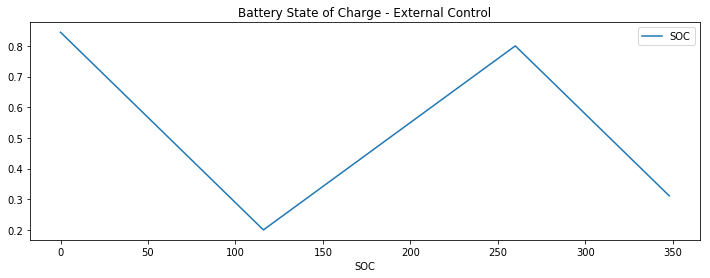

In [10]:
Logger.log_dict['bsd_1'].keys()
# Logger.log_dict['bsd_1']['SOC']

fig1 = plt.figure(figsize = [12, 4])
plt.plot(Logger.log_dict['bsd_1']['SOC'],label="SOC")
plt.title('Battery State of Charge - External Control')
plt.xlabel('Time [s]')
plt.xlabel('SOC')
plt.legend()

fig1.savefig('/home/michael/Desktop/temp/SOC.png')